# HR-аналитика

## Описание проекта
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. <br> <br>
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. <br> <br>
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. <br> <br>
**Задачи:** 
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [46]:
!pip install phik -q
!pip install -Uq scikit-learn

In [47]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy
from statsmodels.stats import weightstats as stests

from phik.report import plot_correlation_matrix
from phik import report

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Описание данных
Для этой задачи заказчик предоставил данные с признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [48]:
try:
    train_jsr = pd.read_csv('train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('test_features.csv')
    test_target = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    train_jsr = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [49]:
train_jsr.info()
train_jsr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [50]:
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [51]:
test_target.info()
test_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


### Предобработка данных

In [52]:
train_jsr.duplicated().sum()

0

In [53]:
train_jsr.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [54]:
for col in train_jsr.columns:
    print(train_jsr[col].unique())

[155278 653870 184592 ... 533318 706868 338347]
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
[ 2  1  4  7  9  6  3 10  8  5]
['no' 'yes']
['no' 'yes']
[1 5 2 3 4]
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]
[0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91
 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53

In [55]:
train_jsr['level'] = train_jsr['level'].replace('sinior', 'senior')

In [56]:
test_jsr = test_features.merge(test_target, on='id')

In [57]:
test_jsr.duplicated().sum()

0

In [58]:
test_jsr.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [59]:
for col in test_jsr.columns:
    print(test_jsr[col].unique())

[485046 686555 467458 ... 305653 160233 771859]
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]
[0.79 0.72 0.64 0.6  0.75 0.67 0.36 0.73 0.44 0.22 0.31 0.46 0.37 0.12
 0.33 0.57 0.24 0.2  0.83 0.76 0.49 0.41 0.47 0.82 0.68 0.8  0.5  0.59
 0.62 0.85 0.78 0.87 0.17 0.45 0.7  0.42 0.63 0.43 0.61 0.77 0.4  1.
 0.66 0.69 0.34 0.84 0.06 0.89 0.1  0.23 0.13 0.51 0.07 0.19 0.35 0.55
 0.32 0.11 0.86 0.3  0.03 0.71 0.88 0.54 0.56 0.21 0.96 0.91 0.38 0.74
 0.5

In [60]:
train_jsr['level'] = train_jsr['level'].replace('sinior', 'senior')
test_jsr['dept'] = test_jsr['dept'].replace(' ', np.nan)
test_jsr['workload'] = test_jsr['workload'].replace(' ', np.nan)

### Итог
- Дубликаты отсутствуют;
- Опечатки исправлены;
- Пробелы заменены np.nan;
- Выявлены пропуски, которые будет необходимо заменить перед обучением модели с помощью пайплайна.

### Исследовательский анализ данных

In [61]:
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
col_features = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [62]:
def plot_cat_1(column):
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    plt.title(f'{column} (train)')
    inf = train_jsr[column].value_counts()
    sns.barplot(x=inf.index, y=inf)
    
    plt.subplot(1, 2, 2)
    plt.title(f'{column} (test)')
    inf = test_jsr[column].value_counts()
    sns.barplot(x=inf.index, y=inf)

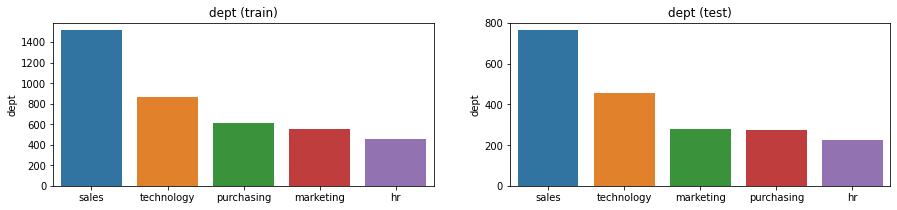

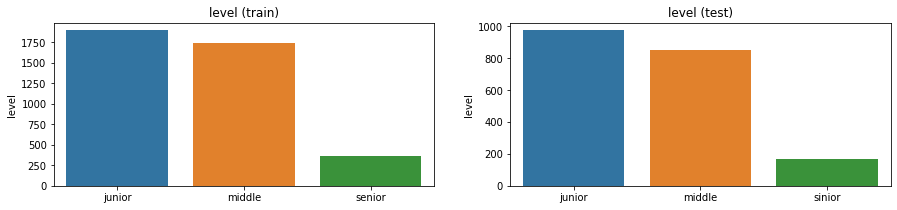

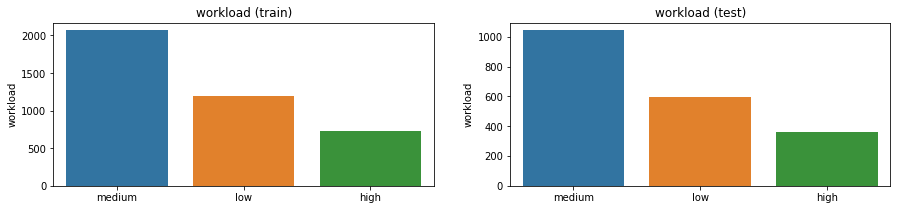

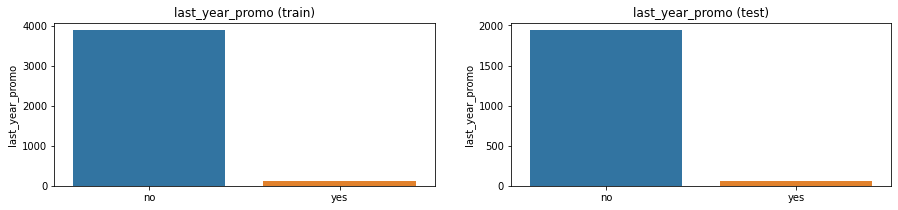

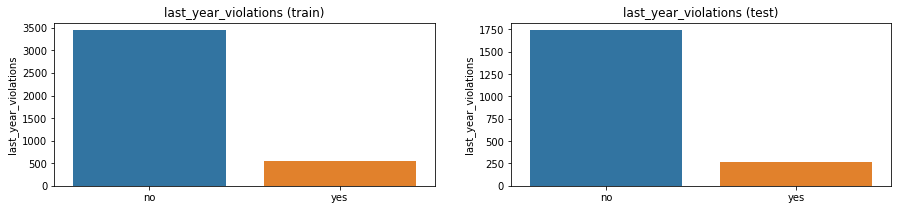

In [63]:
for col in cat_features:
    plot_cat_1(col)

В тренировочной и тестовой выборках сохранены одинаковые пропорции для категориальных признаков. Большинство испытуемых работает в отделах Sales и Technology. В основном рассматриваются Junior и Middle. Medium уровень загруженности для большинства работников. Почти 95% работников не имели повышения в прошлом году. Только седьмая часть от испытуемых нарушала трудовой договор в прошлом году.

In [64]:
def plot_col(df, column):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    plt.title(f'{column}')
    sns.histplot(df[column])
    plt.subplot(1, 2, 2)
    plt.title(f'{column}')
    sns.boxplot(x=df[column])

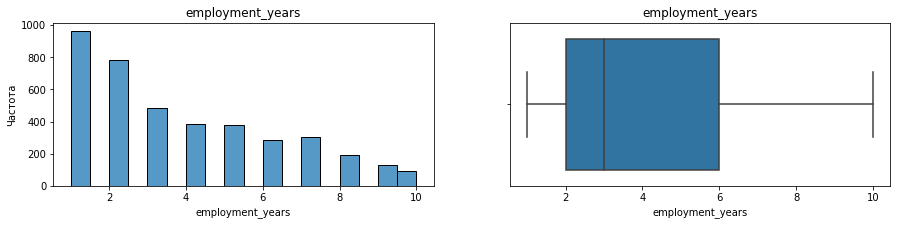

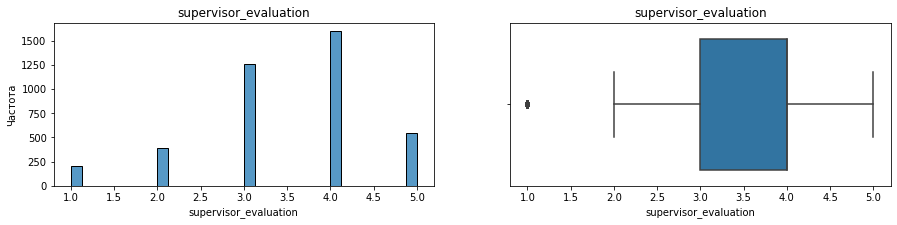

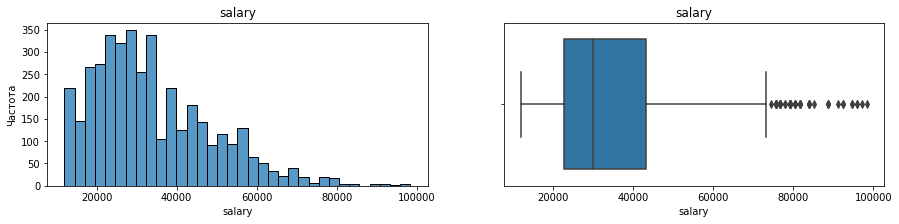

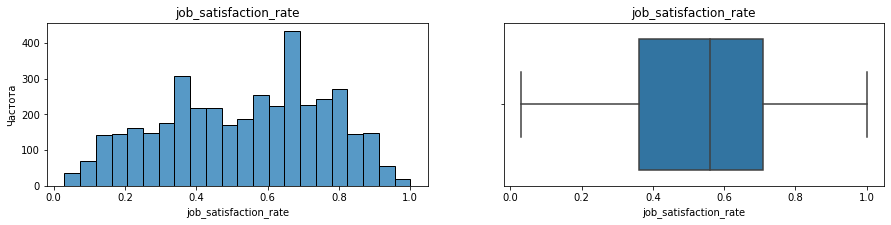

In [65]:
for col in col_features:
    plot_col(train_jsr, col)

In [66]:
for i in col_features:
    stat, p_val = shapiro(train_jsr[i])
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение employment_years не нормальное
Распределение supervisor_evaluation не нормальное
Распределение salary не нормальное
Распределение job_satisfaction_rate не нормальное


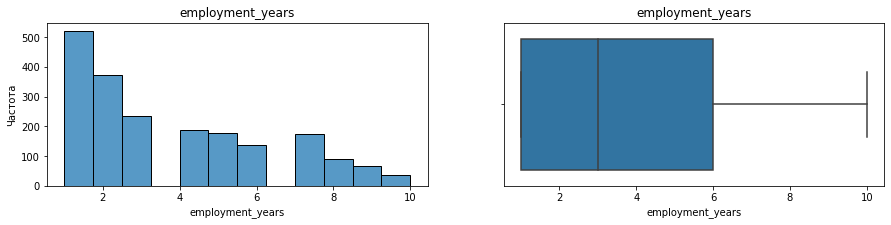

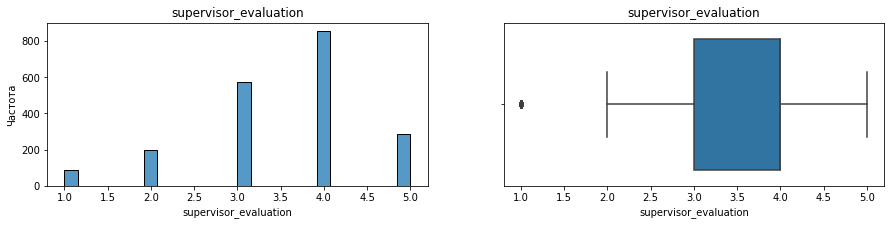

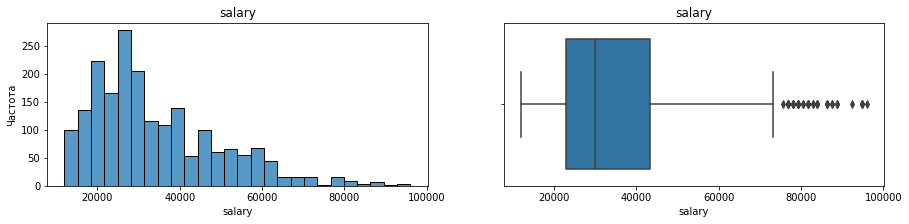

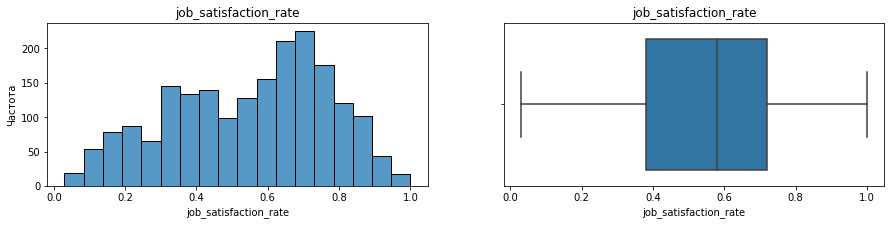

In [67]:
for col in col_features:
    plot_col(test_jsr, col)

In [68]:
for i in col_features:
    stat, p_val = shapiro(test_jsr[i])
    if p_val < 0.05: 
        print(f'Распределение {i} не нормальное')
    else: 
        print(f'Распределение {i} нормальное')

Распределение employment_years не нормальное
Распределение supervisor_evaluation не нормальное
Распределение salary не нормальное
Распределение job_satisfaction_rate не нормальное


Данные в тестовой и тренировочной выборках похожи. Все количественные признаки распределены не нормально. Имеются аномальные значения в зарплате и оценке качества работника, но удалять не будем, так как такие данные объяснимы.

### Корреляционный анализ

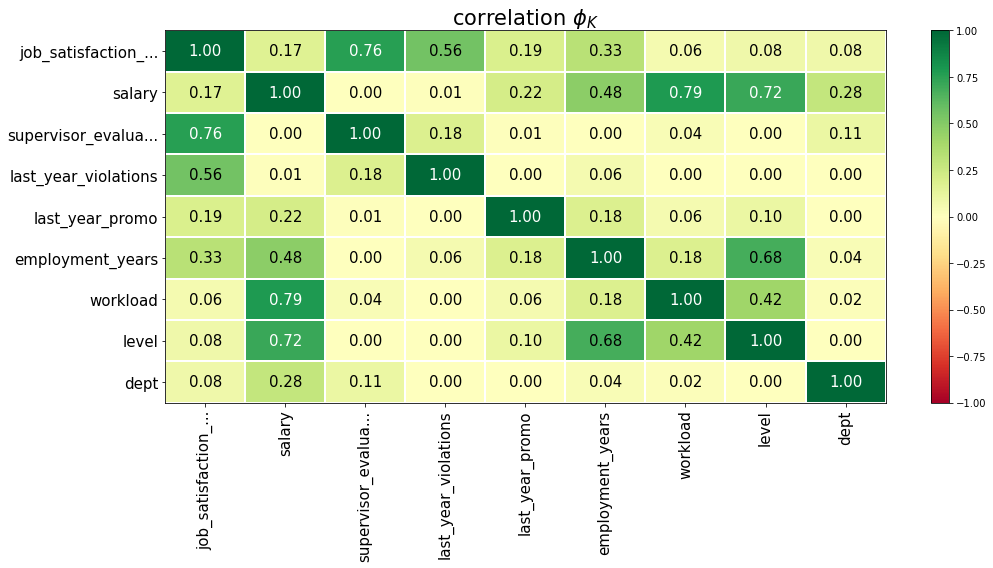

In [69]:
phik_overview = train_jsr.drop('id', axis=1).phik_matrix(interval_cols=\
                ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

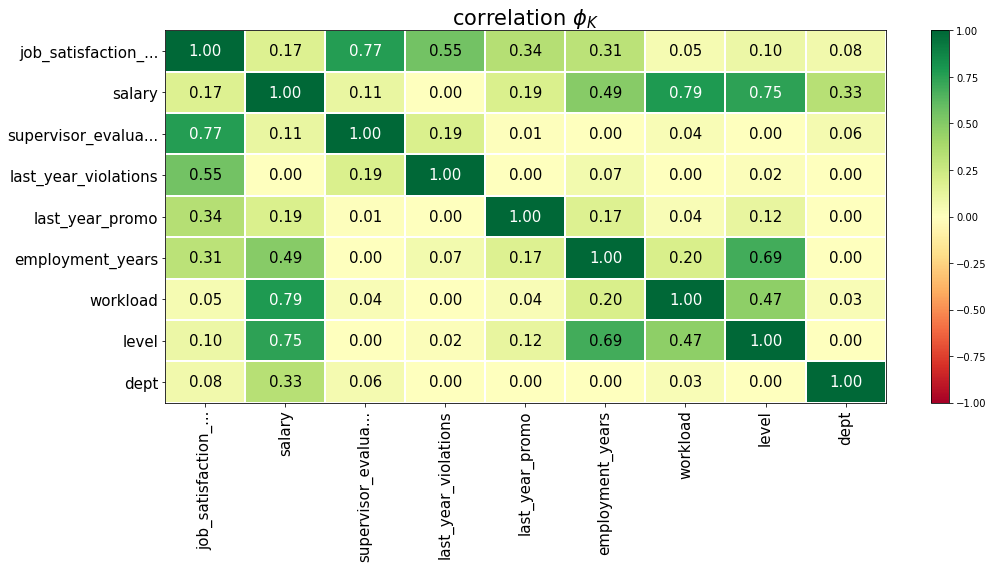

In [70]:
phik_overview = test_jsr.drop('id', axis=1).phik_matrix(interval_cols=\
                ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'])

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

Ни в тренировочной, ни в тестовой выборке мультиколлинеарность не выявлена. Коэффициент корреляции не превышает 0.79.

### Итог анализа данных
- В тренировочной и тестовой выборках сохранены одинаковые пропорции для категориальных признаков. 
- Большинство испытуемых работает в отделах Sales и Technology. 
- В основном рассматриваются Junior и Middle. 
- Medium уровень загруженности для большинства работников. 
- Почти 95% работников не имели повышения в прошлом году. 
- Только седьмая часть от испытуемых нарушала трудовой договор в прошлом году.
- Количественные данные в тестовой и тренировочной выборках похожи. 
- Все количественные признаки распределены не нормально.
- Испытуемые в среднем работают в компании 3 года. В данных представлена сотрудники, которые работают в компании от года.
- Имеют оценку супервизора - 3.5 из 5.
- Зарабатывают примерно 30 000 денежных единиц.
- Имеются аномальные значения в зарплате и оценке качества работника, но удалять не будем, так как такие данные объяснимы.
- Ни в тренировочной, ни в тестовой выборке мультиколлинеарность не выявлена. Коэффициент корреляции не превышает 0.79.

### Подготовка данных

In [71]:
X_train_d = train_jsr.drop('id', axis=1)
X_train_d.drop_duplicates(inplace=True)
X_test_d = test_jsr.drop('id', axis=1)
X_test_d.drop_duplicates(inplace=True)

In [72]:
X_train = X_train_d.drop('job_satisfaction_rate', axis=1)
y_train = X_train_d['job_satisfaction_rate']
X_test = X_test_d.drop('job_satisfaction_rate', axis=1)
y_test = X_test_d['job_satisfaction_rate']

In [73]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [74]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [75]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']], 
                               handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [76]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [77]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [78]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 15),
        'models__max_features': range(3, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [79]:
def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

scorer = make_scorer(smape, greater_is_better=False)

In [80]:
grid = GridSearchCV(pipe_final,
                   param_grid,
                   cv=5,
                   scoring=scorer,
                   n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_promo',
                                                                          'last_year_violations',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(3, 15),
                          'models__max_features': range(3, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [81]:
best_model = grid.best_estimator_
print('Лучшая модель и её параметры:', grid.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_*(-1))

Лучшая модель и её параметры: {'models': LinearRegression(), 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на тренировочной выборке: 25.005621272180875


In [82]:
print(f'Метрика SMAPE лучшей модели на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)), 4)}')

Метрика SMAPE лучшей модели на тестовой выборке: 27.2827


### Общий вывод
- Получить SMAPE $\leq 15$ не получилось
- Для поиска лучшей модели были предприняты следующие шаги:
    - Проведено исследование полученных даных и признаков;
    - В процессе поиска к данным применено 2 типа моделей классифкации;
    - на основе метрики SMAPE была отобрана лучшая модель ('models', DecisionTreeRegressor(max_depth=13, max_features=11, random_state=100) c использованием пайплайна;
    - метрика SMAPE лучшей модели на тренировочной выборке составила: 14.5585

## Задача 2: предсказание увольнения сотрудника из компании

### Описание данных

In [83]:
try:
    train_quit = pd.read_csv('train_quit.csv')
    test_features = pd.read_csv('test_features_2.csv')
    test_target_quit = pd.read_csv('test_target_quit.csv')
except:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [84]:
train_quit.info()
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [85]:
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [86]:
test_target_quit.info()
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


### Предобработка данных

In [87]:
train_quit.duplicated().sum()

0

In [88]:
train_quit.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

In [89]:
for col in train_quit.columns:
    print(train_quit[col].unique())

[723290 814010 155091 ... 536432 692133 853842]
['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
[ 2  5  1  8  4  7  3  9  6 10]
['no' 'yes']
['no' 'yes']
[4 1 3 5 2]
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87600 75600 91200 76800 74400 80400 85200 86400 92400]
['no' 'yes']


In [90]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

In [91]:
test_features.duplicated().sum()

0

In [92]:
test_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

In [93]:
for col in test_features.columns:
    print(test_features[col].unique())

[485046 686555 467458 ... 305653 160233 771859]
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
[ 2  1  5  6  3  9  7  4  8 10]
['no' 'yes']
['no' 'yes']
[5 4 3 1 2]
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


In [94]:
test_features['level'] = test_features['level'].replace('sinior', 'senior')
test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [95]:
test_features.duplicated().sum()

0

In [96]:
test_target_quit.isna().sum()

id      0
quit    0
dtype: int64

In [97]:
for col in test_target_quit.columns:
    print(test_target_quit[col].unique())

[999029 372846 726767 ... 746018 247658 460332]
['yes' 'no']


In [98]:
test_quit = test_features.merge(test_target_quit, on='id')

### Итог
- Дубликаты отсутствуют;
- Опечатки исправлены;
- Пробелы заменены np.nan;
- Выявлены пропуски, которые будет необходимо заменить перед обучением модели с помощью пайплайна.

### Исследовательский анализ

In [99]:
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
col_features = ['employment_years', 'supervisor_evaluation', 'salary']

In [100]:
def plot_cat_2(column):
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 2, 1)
    plt.ylabel('Частота')
    plt.title(f'{column} (train)')
    inf = train_quit[column].value_counts()
    sns.barplot(x=inf.index, y=inf)
    
    plt.subplot(1, 2, 2)
    plt.title(f'{column} (test)')
    inf = test_quit[column].value_counts()
    sns.barplot(x=inf.index, y=inf)

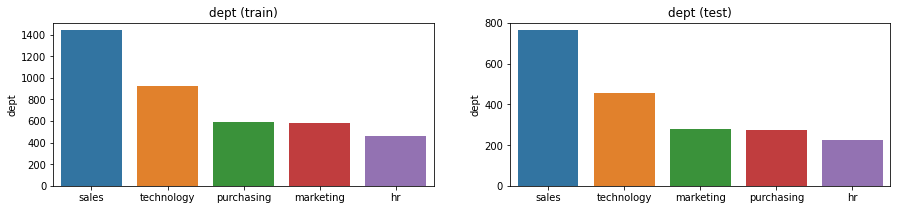

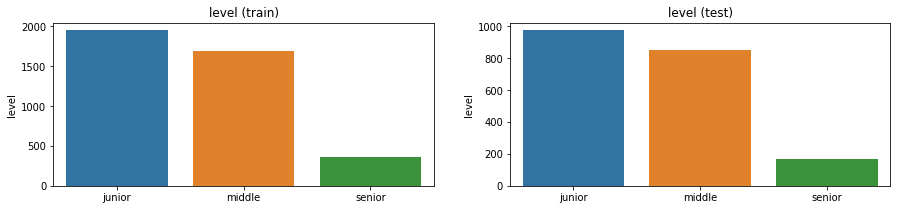

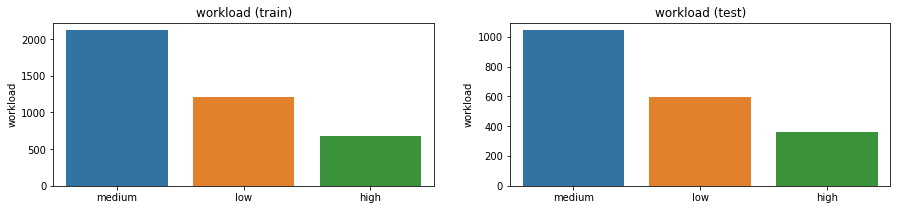

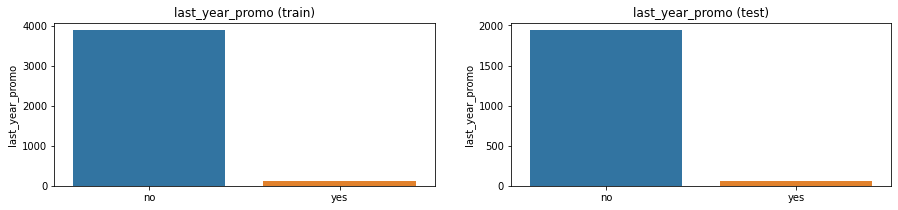

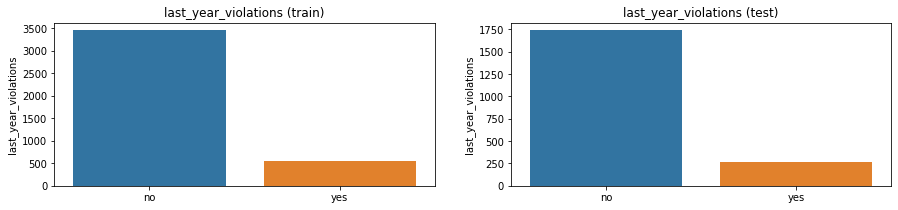

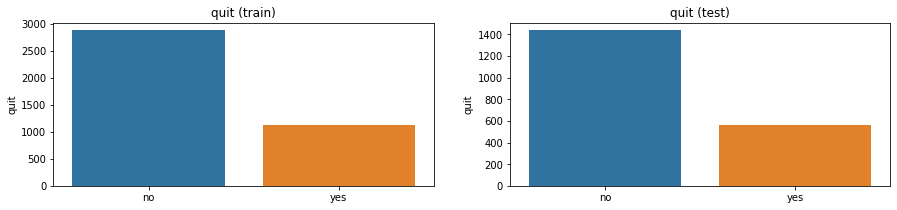

In [101]:
for col in cat_features:
    plot_cat_2(col)

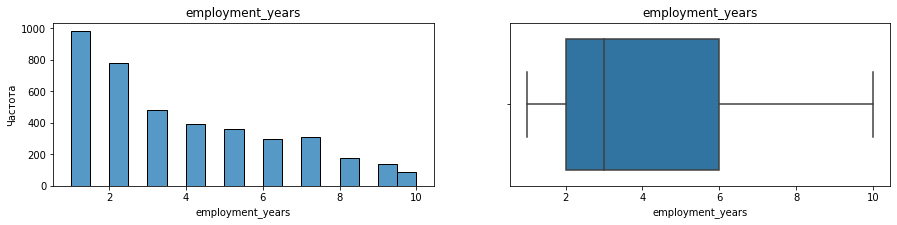

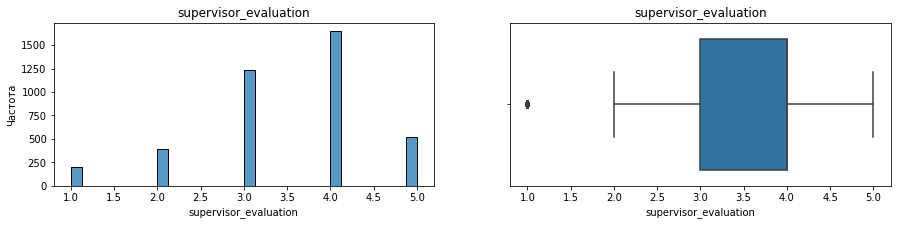

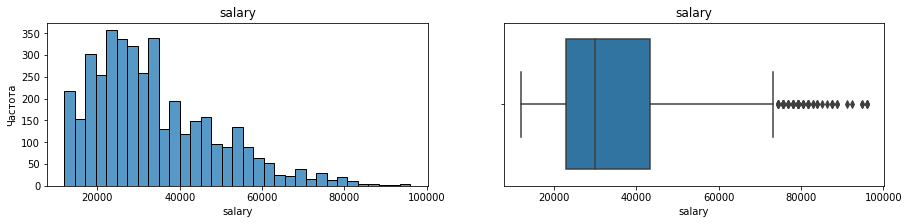

In [102]:
for col in col_features:
    plot_col(train_quit, col)

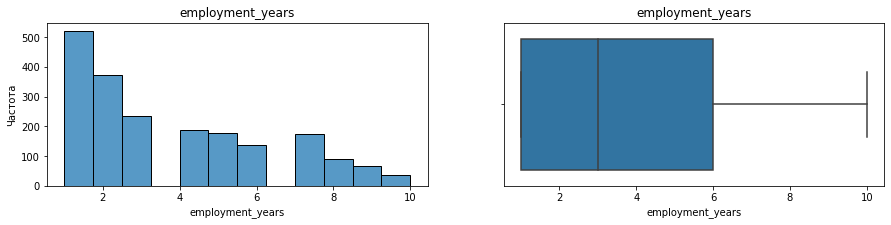

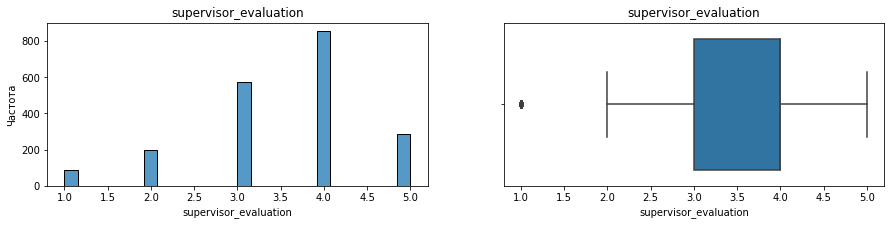

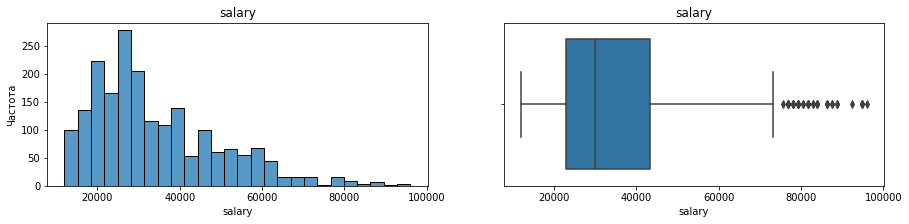

In [103]:
for col in col_features:
    plot_col(test_quit, col)

In [104]:
def hist_plot(column, target):
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 2, 1)
    plot = sns.histplot(train_quit, bins=20, kde=True, hue=target, x=column, stat='density', common_norm=False)
    plot.set_title(column)
    plot.set_ylabel('Частота')
    plot.set_title(f'{column} (train)')
    
    plt.subplot(1, 2, 2)
    plot = sns.histplot(test_quit, bins=20, kde=True, hue=target, x=column, stat='density', common_norm=False)
    plot.set_title(column)
    plot.set_ylabel('Частота')
    plot.set_title(f'{column} (test)')
    
    plt.show()

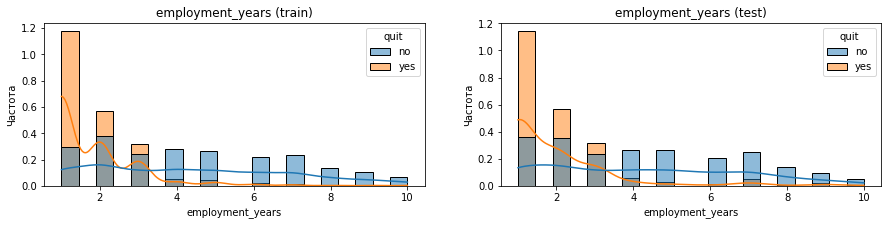

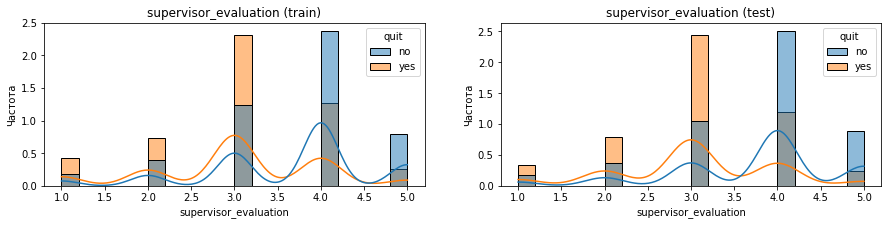

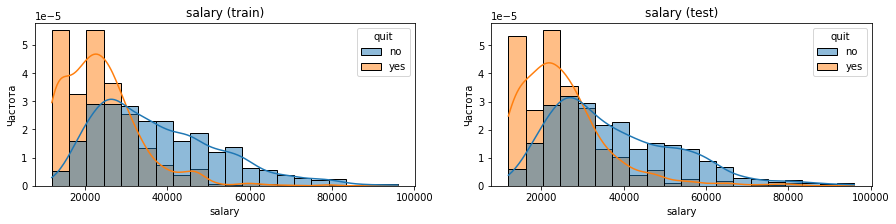

In [105]:
for col in col_features:
    hist_plot(col, 'quit')

In [106]:
def prop_plot(column):
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 2, 1)
    df = train_quit.query("quit == 'yes'").groupby(column).count()['quit'] / train_quit.groupby(column).count()['quit']
    sns.barplot(x=df.index, y=df).set_title(f'Доля уволенных сотрудников по {column}')
    plt.ylabel('Доля')
    
    plt.subplot(1, 2, 2)
    df = test_quit.query("quit == 'yes'").groupby(column).count()['quit'] / train_quit.groupby(column).count()['quit']
    sns.barplot(x=df.index, y=df).set_title(f'Доля уволенных сотрудников по {column}')
    plt.ylabel('Доля')
    
    plt.show()

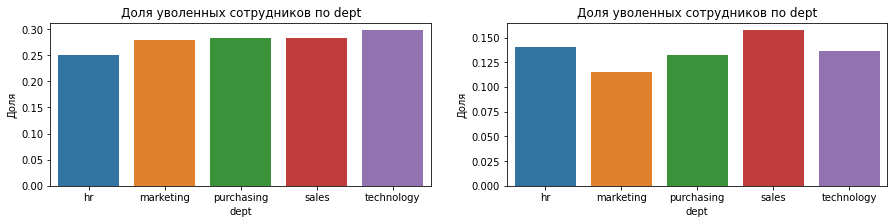

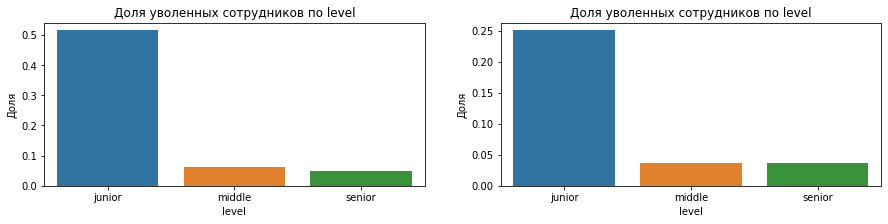

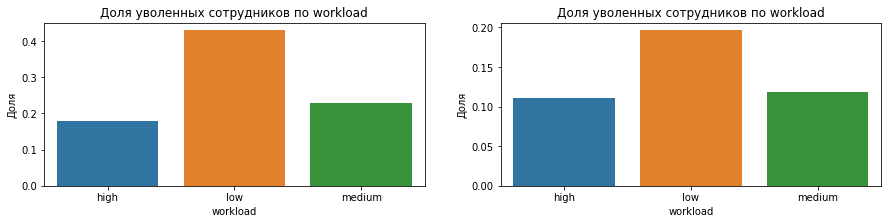

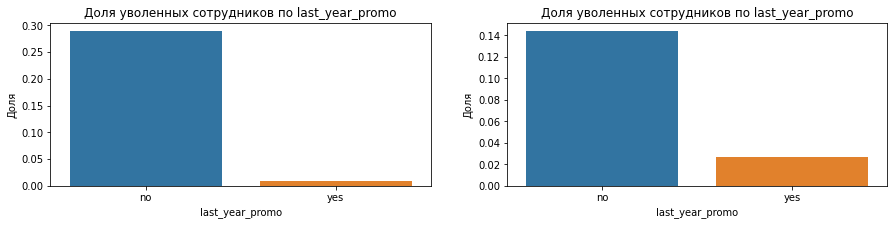

In [107]:
for col in cat_features[:4]:
    prop_plot(col)

interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


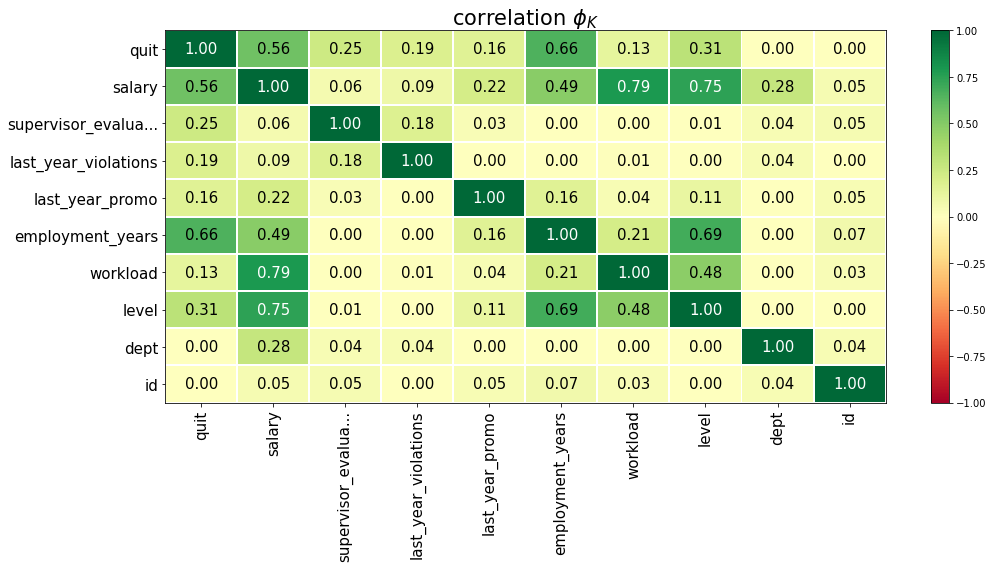

In [108]:
phik_overview = train_quit.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


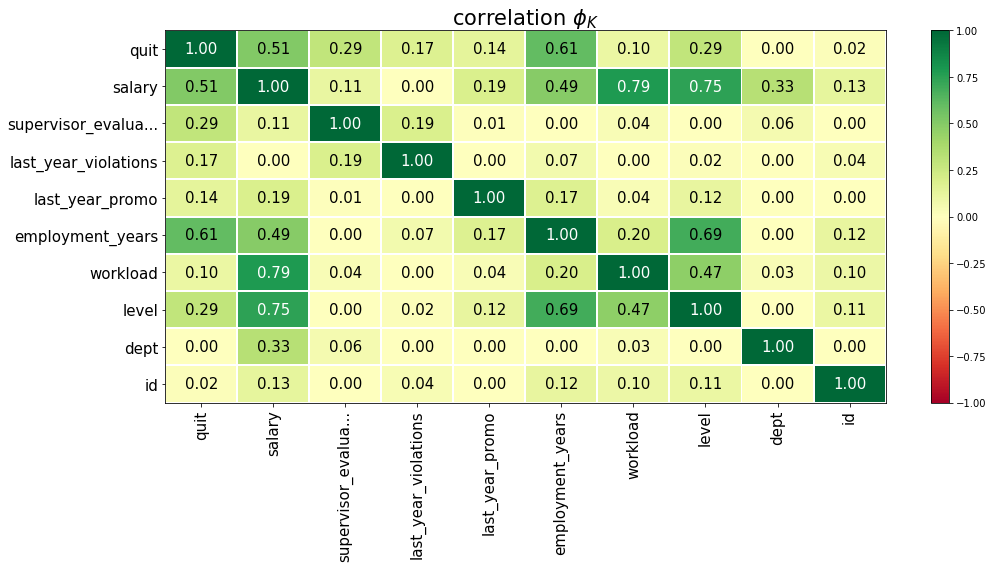

In [109]:
phik_overview = test_quit.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 8)
)

In [110]:
test_quit_jsr = test_quit.merge(test_jsr, on='id')

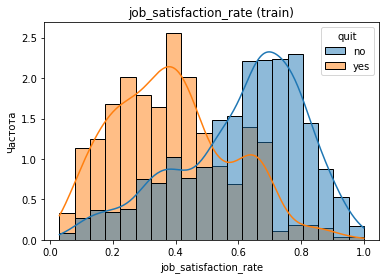

In [111]:
plot = sns.histplot(test_quit_jsr, bins=20, kde=True, hue='quit', x='job_satisfaction_rate', stat='density', common_norm=False)
plot.set_title('job_satisfaction_rate')
plot.set_ylabel('Частота')
plot.set_title(f'job_satisfaction_rate (train)')
plt.show()

Сформулируем гипотезы: <br>
$H_0$: уровень удовлетворённости сотрудника работой в компании не влияет на то, уволится ли сотрудник. (Среднее значение коэффициента уволенных равно среднему значению коэффициента оставшихся) <br>
$H_1$: уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. (Среднее значение коэффициента уволенных не равно среднему значению коэффициента оставшихся)

In [112]:
df1 = test_quit_jsr.query("quit == 'yes'")['job_satisfaction_rate']
df2 = test_quit_jsr.query("quit == 'no'")['job_satisfaction_rate']

In [113]:
if scipy.stats.kstest(df1, 'norm', args=(np.mean(df1), np.std(df1, ddof=1)))[1] >= 0.2:
    print('Гипотеза о том, что выборка Х распределена нормально, не отвергается')
else:
    print('Это ненормаьное распределение')

Это ненормаьное распределение


Это ненормальное распределение. Воспользуемся ассимптотическим z-test, учитывая, что ЦПТ выполнено.

In [114]:
if stests.ztest(x1=df1, x2=df2)[1] < 0.05:
    print('Гипотеза отвергается')
else:
    print('Гипотеза не отвергается')

Гипотеза отвергается


Следовательно, уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

### Итог Исследовательского анализа
- Мультиколлинеарность не выявлена;
- Доли в тренировочной и тестовой выборках сохранены;
- Портрет уволившегося сотрудника:
    - Отработал 1-2 года;
    - Имел оценку 3 из 5 от руководителя;
    - Зарабатывал в диапазоне от 10000 до 30000;
    - Наиболее вероятно, что работал в отделе technology;
    - Имел уровень Junior;
    - Имел низкую нагрузку;
    - Не имел повышений на протяжении прошлого года;
    - Коэффициент удовлетворенности работой был ниже 0.5. В среднем - 0.3.
- Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник

### Добавление нового признака

In [115]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)
test_quit['job_satisfaction_rate'] = best_model.predict(test_quit)

In [116]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.553253
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.643547
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.224210
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.297650
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.712024


### Подготовка признаков

In [117]:
X_train = train_quit.drop(['quit', 'id'], axis=1)
y_train = train_quit['quit'] 
X_test = test_quit.drop(['quit', 'id'], axis=1)
y_test = test_quit['quit']

ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [118]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [119]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['junior', 'middle', 'senior'], ['low', 'medium', 'high']], 
                               handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [120]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [121]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

In [122]:
param_grid = [

    {
        'models': [RandomForestClassifier()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(10, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

In [123]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_promo',
                                                                          'last_year_violations',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(...
                                                'passthrough']},
                         {'models': [DecisionTreeClassifier(random_state=42)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(10, 20),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [124]:
best_model = grid_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)
print(f'Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: {round(grid_search.best_score_, 4)}')

Лучшая модель и её параметры:

 {'models': RandomForestClassifier(), 'preprocessor__num': StandardScaler()}
Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: 0.9272


In [125]:
print(f'Метрика ROC-AUC лучшей модели на тестовой выборке: \
{round(roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]), 4)}')

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.9269
